In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.datasets.utils import download_and_extract_archive
from torchvision import datasets, transforms, models
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Preparation

In [ ]:
# Download the data and unzip from github repo

!wget https://github.com/laxmimerit/dog-cat-full-dataset/archive/refs/heads/master.zip -P /content
!unzip /content/master.zip -d /content/dog-cat
!ls /content/dog-cat/dog-cat-full-dataset-master/data

In [4]:
 # Define the transforms
transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),  # Resize images
    transforms.ToTensor(),              # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Set the paths to the dataset directories
train_dir = '/content/dog-cat/dog-cat-full-dataset-master/data/train'
test_dir = '/content/dog-cat/dog-cat-full-dataset-master/data/test'

# Load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Get the indices for the subsets
train_indices = torch.randperm(len(train_dataset)).tolist()[:4000]  # Randomly select 4000 training images

# Create training subset
train_subset = Subset(train_dataset, train_indices)

# Get indices for validation and test data (split 800 for validation and 800 for testing from the test dataset)
test_indices = torch.randperm(len(test_dataset)).tolist()  # Randomly shuffle the test set
val_indices = test_indices[:800]  # Select 800 for validation
test_indices = test_indices[800:1600]  # Select 800 for test data

# Create validation and test subsets
val_subset = Subset(test_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)

# Create DataLoaders for the subsets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Print dataset size
print(f"Training data: {len(train_subset)} images")
print(f"Validation data: {len(val_subset)} images")
print(f"Test data: {len(test_subset)} images")

Training data: 4000 images
Validation data: 800 images
Test data: 800 images


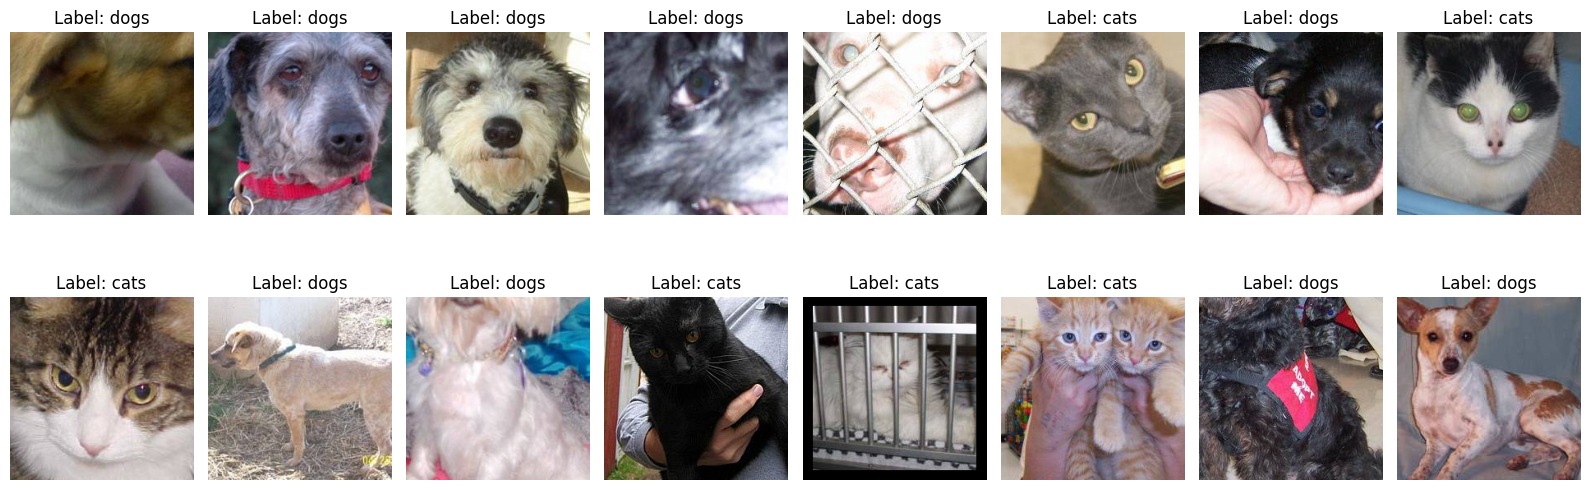

In [5]:
import numpy as np

# Get a batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Define class labels (adjust based on your dataset, assuming 'dog' and 'cat')
class_names = train_dataset.classes

# Plot the images in the batch with labels
fig, axes = plt.subplots(2, 8, figsize=(16, 6))  # Adjust the grid size based on the batch size
axes = axes.flatten()

# Display each image in the batch
for i in range(16):  # For each image in the batch
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy for displaying
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)  # Denormalize
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {class_names[labels[i]]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Load the pretrained ResNet Model

In [17]:
# Load a pre-trained ResNet50 model

model = (models.resnet50(pretrained=True))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


In [18]:
 # Freeze all layers

for param in model.parameters():
    param.requires_grad = False

In [19]:
# Modify the last fully connected layer

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Training ResNet (Transfer Learning)

In [22]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

num_epochs = 20

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Model's prediction
        loss = criterion(outputs, labels)  # Calculate loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the class with max score
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Log training loss and accuracy at each batch
        if (i + 1) % 10 == 0:  # Log every 10 batches (you can adjust the frequency)
            avg_train_loss = running_loss / (i + 1)
            train_accuracy = correct_train / total_train * 100

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Append training loss and accuracy to their respective lists
    train_loss_list.append(avg_train_loss)
    train_accuracy_list.append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation
        for i, (inputs, labels) in enumerate(val_loader):  # Loop through validation dataset
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)  # Get the class with max score
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Log validation loss and accuracy at each batch
            if (i + 1) % 10 == 0:  # Log every 10 batches (you can adjust the frequency)
                avg_val_loss = val_loss / (i + 1)
                val_accuracy = correct_val / total_val * 100

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100

    # Append validation loss and accuracy to their respective lists
    val_loss_list.append(avg_val_loss)
    val_accuracy_list.append(val_accuracy)

    # Print training and validation metrics
    print(f"Epoch {epoch + 1:03d} |", end=' ')
    print(f"Training Loss: {avg_train_loss: .4f} |", end=' ')
    print(f"Training Accuracy: {train_accuracy: .2f}% |", end=' ')
    print(f"Validation Loss: {avg_val_loss: .4f} |", end=' ')
    print(f"Validation Accuracy: {val_accuracy: .2f}%")

Epoch 001 | Training Loss:  0.2607 | Training Accuracy:  91.07% | Validation Loss:  0.1027 | Validation Accuracy:  98.12%
Epoch 002 | Training Loss:  0.0987 | Training Accuracy:  97.40% | Validation Loss:  0.0799 | Validation Accuracy:  98.50%
Epoch 003 | Training Loss:  0.0822 | Training Accuracy:  97.70% | Validation Loss:  0.0721 | Validation Accuracy:  98.38%
Epoch 004 | Training Loss:  0.0713 | Training Accuracy:  97.92% | Validation Loss:  0.0629 | Validation Accuracy:  98.50%
Epoch 005 | Training Loss:  0.0725 | Training Accuracy:  97.58% | Validation Loss:  0.0599 | Validation Accuracy:  98.12%
Epoch 006 | Training Loss:  0.0660 | Training Accuracy:  98.05% | Validation Loss:  0.0581 | Validation Accuracy:  98.75%
Epoch 007 | Training Loss:  0.0597 | Training Accuracy:  98.15% | Validation Loss:  0.0532 | Validation Accuracy:  99.00%
Epoch 008 | Training Loss:  0.0537 | Training Accuracy:  98.40% | Validation Loss:  0.0554 | Validation Accuracy:  98.88%
Epoch 009 | Training Los

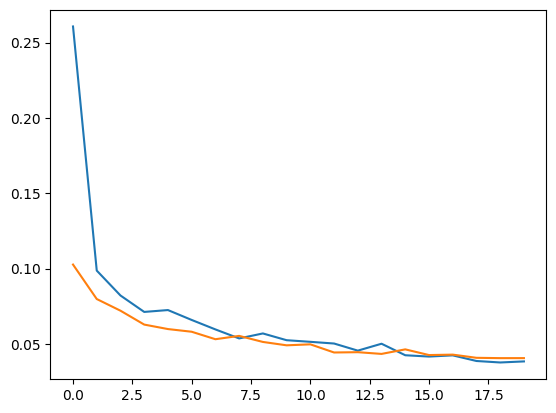

In [23]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

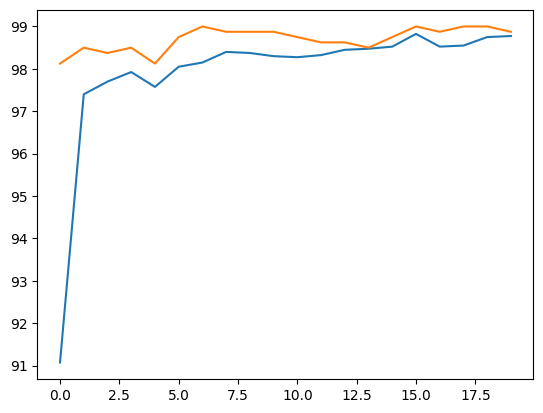

In [24]:
plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

In [27]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Models/ResNet_model.pth")

# Evaluation

In [25]:
 # Evaluate on the test data
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Track statistics
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.75%


# Load the pretrained ConvNextV2 Model

In [6]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification

processor = ConvNextImageProcessor.from_pretrained("facebook/convnext-base-224")
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-base-224")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/354M [00:00<?, ?B/s]

In [8]:
 # Freeze all layers

for param in model.parameters():
    param.requires_grad = False

In [9]:
# Modify the last fully connected layer

num_classes = 2
model.classifier = nn.Linear(1024, num_classes)
model = model.to(device)

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training ConvNextV2 (Transfer Learning)

In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors
])

# Load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Get the indices for the subsets
train_indices = torch.randperm(len(train_dataset)).tolist()[:4000]  # Randomly select 4000 training images

# Create training subset
train_subset = Subset(train_dataset, train_indices)

# Get indices for validation and test data (split 800 for validation and 800 for testing from the test dataset)
test_indices = torch.randperm(len(test_dataset)).tolist()  # Randomly shuffle the test set
val_indices = test_indices[:800]  # Select 800 for validation
test_indices = test_indices[800:1600]  # Select 800 for test data

# Create validation and test subsets
val_subset = Subset(test_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)

# Create DataLoaders for the subsets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)


In [13]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        # Preprocess images and move to device
        inputs = processor(images, return_tensors="pt").to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(logits, dim=1)  # Get the class with max score
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Append training loss and accuracy to their respective lists
    train_loss_list.append(avg_train_loss)
    train_accuracy_list.append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation
        for i, (images, labels) in enumerate(val_loader):
            # Preprocess images and move to device
            inputs = processor(images, return_tensors="pt").to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)

            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(logits, dim=1)  # Get the class with max score
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100

    # Append validation loss and accuracy to their respective lists
    val_loss_list.append(avg_val_loss)
    val_accuracy_list.append(val_accuracy)

    # Adjust learning rate
    scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1:03d} |", end=' ')
    print(f"Training Loss: {avg_train_loss: .4f} |", end=' ')
    print(f"Training Accuracy: {train_accuracy: .2f}% |", end=' ')
    print(f"Validation Loss: {avg_val_loss: .4f} |", end=' ')
    print(f"Validation Accuracy: {val_accuracy: .2f}%")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch 001 | Training Loss:  0.4732 | Training Accuracy:  78.60% | Validation Loss:  0.4003 | Validation Accuracy:  80.38%
Epoch 002 | Training Loss:  0.3715 | Training Accuracy:  82.53% | Validation Loss:  0.3497 | Validation Accuracy:  83.12%
Epoch 003 | Training Loss:  0.3412 | Training Accuracy:  84.42% | Validation Loss:  0.3298 | Validation Accuracy:  85.00%
Epoch 004 | Training Loss:  0.3251 | Training Accuracy:  85.38% | Validation Loss:  0.3379 | Validation Accuracy:  82.75%
Epoch 005 | Training Loss:  0.3143 | Training Accuracy:  85.55% | Validation Loss:  0.3098 | Validation Accuracy:  85.12%
Epoch 006 | Training Loss:  0.3014 | Training Accuracy:  86.42% | Validation Loss:  0.3009 | Validation Accuracy:  87.38%
Epoch 007 | Training Loss:  0.3013 | Training Accuracy:  86.90% | Validation Loss:  0.2995 | Validation Accuracy:  87.38%
Epoch 008 | Training Loss:  0.3003 | Training Accuracy:  86.72% | Validation Loss:  0.2979 | Validation Accuracy:  87.00%
Epoch 009 | Training Los

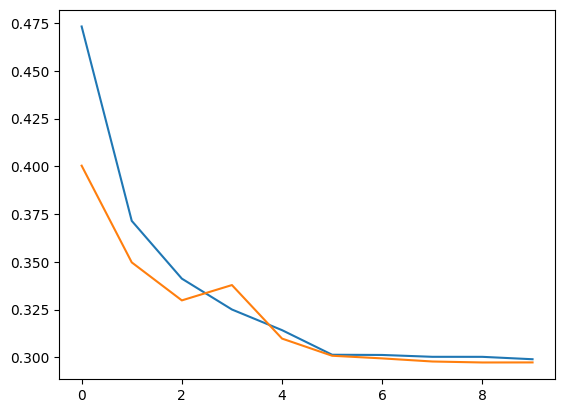

In [14]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

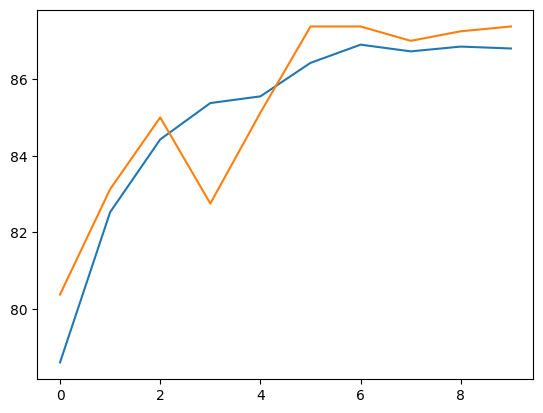

In [15]:
plt.plot(train_accuracy_list)
plt.plot(val_accuracy_list)

# Evaluation

In [16]:
# Test phase for accuracy only
model.eval()  # Set the model to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():  # Disable gradient computation
    for images, labels in test_loader:
        # Preprocess images and move to device
        inputs = processor(images, return_tensors="pt").to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Calculate test accuracy
        _, predicted = torch.max(logits, dim=1)  # Get the class with max score
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = correct_test / total_test * 100

# Print test accuracy
print(f"Test Accuracy: {test_accuracy: .2f}%")

Test Accuracy:  85.12%
